# Análisis de series de tiempo con fbprophet

Prophet es un software lanzado por el equipo Core Data Science de Facebook (Meta) y hecho en código abierto para que la comunidad científica pueda contribuir.

Prophet es un procedimiento para pronosticar series de tiempo  en el que las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, además de los efectos de fechas especiales. 
Funciona mejor con series temporales que tienen fuertes efectos estacionales y varias temporadas de datos históricos. 


Prophet maneja adecuadamente a los datos faltantes y los cambios en la tendencia, y por lo general maneja bien los valores atípicos.

Se encuentra disponible tanto en R como en python y es una herramienta rápida, automatizada con gran variedad de funciones incluidas y altamente ajustable a nuestras necesidades.


<img src="https://miro.medium.com/max/964/0*tVCene42rgUTNv9Q.png" style="height: 200px; width:800px; display: block; margin-left: auto; margin-right: auto;"/>

Prophet es está basado en Modelo Regresivo Aditivo (MRA) en el que las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, además de los efectos de las vacaciones
El modelo esta dado por la siguiente ecuación:

\
$
\begin{align}
\mathbf{y(t)} = \mathbf{g(t)} + \mathbf{h(t)} + \mathbf{s(t)} + \mathbf{\epsilon}
\end{align}
$

Donde:
* $y(t)$: MRA
* $g(t)$: Componente de tendencia
* $h(t)$: Componente de holidays
* $s(t)$: Componente estacional
* $\epsilon(t)$: Componente del error

### $g(t)$ Componente de tendencia

Prophet tiene implementado dos posibles modelos de tendencia.


\
**a) Logistic Growth Model**

Nos permite modelar un crecimiento no lineal con saturación, es decir, un crecimiento exponencial al principio y finalizando de forma aritmética hasta llegar a un punto máximo 


Aquí podemos ver un ejemplo de un crecimiento no lineal con saturación.\
<br>
<img src="https://miro.medium.com/max/1238/1*gcKfLuupziw8ZZTs62tNPA.png" style="height: 400px; width:800px;"/>
\
\
Estas curvas podemos modelarlas de la siguiente manera:<br>
$
\begin{align}
\mathbf{f(x)} = \mathbf{\dfrac{L}{1+e^{-kx}}} 
\end{align}
$

Donde:<br>
* $L$: Valor máximo de la curva
* $k$: Tasa de crecimiento logístico\
<br>




**b) Piecewise Linear Model**


Como su nombre lo indica, es una sencilla regresión lineal a trozos.


Es común que una regresión lineal no explique nuestros datos por completo, sin embargo, con Prophet podemos hacerlo de forma automática.

Prophet detecta cuando hay un cambio en la pendiente de los datos analizados y ajusta tantas regresiones como cambios hay aunque siempre existe la opción manual.

Aquí un ejemplo de una regresión lineal a trozos:

<img src="https://miro.medium.com/max/1046/1*MNjgBtsASahdL_AXjfsopg.png" style="height: 400px; width:800px;"/>

\
Sea $\mathbf{c}$ el punto donde cambia la pendiente de los datos, entonces, representa un modelo lineal a trozos cuando un sólo cambio de pendiente.
$$ y=   \left\{
\begin{array}{ll}
      \beta_o + \beta_1x & ; x \leq c \\
      \beta_o - \beta_2 c + (\beta_1+\beta_2)x & ; x > c \\
\end{array} 
\right.  $$

### $s(t)$ Componente estacional


A grandes rasgos, el componente estacional provee al modelo la *flexibilidad* de cambio en la temporalidad de los datos.

Este componente se estima mediante las sumas parciales de Series de Fourier.

<img src="https://miro.medium.com/max/512/1*hBR26OFeHQgRS2XFC3QZMA.gif" style="height: 200px; width:200px;"/>


El orden de la serie determina que tan rápido puede cambiar cambiar la estacionalidad, a mayor orden más rápido es el cambio.<br>
Igualmente, este parámetro es modificable, sin embargo, de no usarlo adecuadamente, tendremos problemas de sobreajuste.

$s(t)$ se expresa de la siguiente manera:

$
\begin{align}
\mathbf{s(t)} = \sum_{n=1}^{N}(a_n cos( \dfrac{2\pi nt}{P}) + b_n sen(\dfrac{2\pi nt}{P})) 
\end{align}
$

En este caso, $\{a_1,..,a_N,b_1,...,b_N\}$ son los parámetros a estimar que dependenden de las estaciones $N$ y $P$, el periodo (356 para información anual, 7 semanal, etc...).



### $h(t)$ Holidays
El efecto de los holidays se añaden al modelo como variables *dummy*, Prophet ya incluye datos de días festivos para algunos paises.<br>
Aunque, para México, no existen registros por el momento, este componente es parametrizable.<br>


Prophet recibe una lista de fechas y cuando cada fecha se hace presente en la predicción, al resultado final suma o resta un valor el cual es calculado a partir de $s(t)$ y $g(t)$ de la información histórica.

### $\epsilon (t)$ Error o ruido

Este parametro resulta relativamente sencillo de entender, por defecto, lo calcula de la siguiente manera:

$
\begin{align}
\mathbf{\epsilon(t)} \sim \mathcal{N} (0, \sigma^2_{obs})
\end{align}
$

Es decir, tiene una distribución Normal, con sd = a la sd observada en los datos. 

### Ventajas y desventajas

| Ventajas    | Desventajas |
| ----------- | ----------- |
| Regularmente efectivo      | Sólo para series de tiempo|
| Fácil uso e interpretación   | Los datos requieren un formato específico        |
| Código abierto y ajustable      | Perfomance varia según el conjunto de datos       |

# Caso Práctico
## Estimación de casos nuevos de covid en Estados Unidos

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import pathlib
from fbprophet import Prophet

### Recopilación de la información
Tomaremos datos con las cifras oficiales del gobierno de Estados Unidos y de estos únicamente conservaremos los siguientes campos:
* 'submission_date'
* 'state'
* 'tot_cases'
* 'new_case' 
* 'tot_death' 
* 'new_death'

La información podemos encontrarla en el siguiente link:<br>
https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36/data

In [2]:
data = pd.read_csv('https://data.cdc.gov/api/views/9mfq-cb36/rows.csv?accessType=DOWNLOAD')
data = data[['submission_date','state', 'tot_cases','new_case','tot_death','new_death']]
data.head()

,submission_date,state,tot_cases,new_case,tot_death,new_death
0,03/11/2021,KS,297229,0,4851,0
1,02/11/2021,TX,2529343,11890,43708,174
2,01/14/2022,KS,621273,19414,7162,21
3,04/13/2020,AL,3859,202,168,8
4,02/12/2021,UT,359641,1060,1785,11


Notamos que los estados vienen abreviados, para un ejercicio posterior, requeriremos el nombre completo del estado, este también lo extraeremos de internet.

In [3]:
cat_states = pd.read_csv("https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv")
cat_states.head()

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


### Limpieza de los datos
Lo primero por hacer es cambiar el estado abreviado por el completo, para esto uniremos con el catálogo de estados y abreviaciones mediante un *inner join*, esto porque la base de datos de contagios contiene algunos valores que no representan estados del país, de esta manera nos desharemos de ellos.

Por requerimiento de la herramienta, las fechas deben llevar el nombre de columna 'ds'

Lo siguiente es convertir las fechas en formato de fecha y finalmente quitar las columnas que estorban para el análisis.

In [4]:
data = data.merge(cat_states, how='inner', left_on='state', right_on='Abbreviation')
data['ds'] = pd.to_datetime(data['submission_date'],errors='coerce') 
data['new_case'] = np.abs(data['new_death'])
data = data.drop(['submission_date','Abbreviation','state'], axis=1)
data.head()

,tot_cases,new_case,tot_death,new_death,State,ds
0,297229,0,4851,0,Kansas,2021-03-11
1,621273,21,7162,21,Kansas,2022-01-14
2,0,0,0,0,Kansas,2020-02-05
3,744493,0,7716,0,Kansas,2022-02-06
4,782802,0,8802,0,Kansas,2022-05-24


Para esta parte, la paquetería *geoplot* contiene información demográfica de estados unidos, de ahí extraeremos la población total por estado.

Esta información tiene formato *geopandas*, por lo que no podremos visualizar los outputs.

In [5]:
import geoplot as gplt
import geopandas as gpd

/Users/1022399/opt/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [6]:
path = gplt.datasets.get_path("contiguous_usa")
contiguous_usa = gpd.read_file(path)

En el próximo chunk uniremos los datos demográficos de estados unidos con nuestra base de contagios y así calcularemos el total de nuevos contagios diarios por cada mil habitantes.

In [7]:
cv19 = contiguous_usa.merge(data, left_on = 'state', right_on= 'State')
cv19["cases_per_mil"] = np.abs(cv19["new_death"] / cv19["population"] * 1000000)
cv19 = cv19.sort_values(by=['ds','State'])

Para este ejercicio haremos un pronóstico de los primeros 30 días de enero 2022 a partir de la historia de 2020 y 2021.

Crearemos dos dataframes:
* train: Datos históricos 2020 y 2021.
* validation: Datos de enero 2022 para verificación de los resultados.

In [9]:
train = cv19[cv19['ds'] < pd.to_datetime("2022-5-1")]

Ahora resestructuramos los datos de formato ancho a formato largo

In [10]:
wtrain = pd.pivot(train, index='ds', columns='state', values='cases_per_mil').reset_index()

## Análisis de series de tiempo con Prophet
Para este ejemplo nos enfocaremos en California, por requerimiento de la paqutería renombraremos la columna 'California' por '$y$'

<AxesSubplot:>

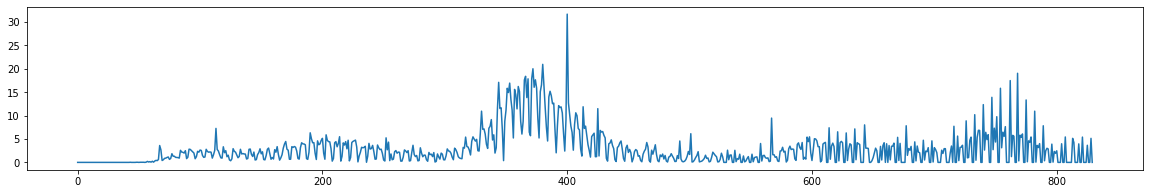

In [11]:
eg = wtrain[['ds','California']].rename(columns = {'California':'y'})
eg['y'].plot(figsize=(20,3))

Para este ejemplo, usaremos la regresión lineal a trozos.

In [12]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_yearly
from fbprophet.diagnostics import cross_validation

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/1022399/opt/miniconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/1022399/opt/miniconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.5242
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1608.61    0.00537645       193.761           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       1616.61   0.000150349       73.6339   1.613e-06       0.001      286  LS failed, Hessian reset 
     199       1616.62   4.42034e-05       65.2229       0.429       0.429      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       1616.63   4.48203e-05        88.442   6.192e-07       0.001      384  LS failed, Hessian reset 
     299       1617.42    0.00662206       106.243           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1619.72   0.000402347       88.7767           1           1      582   
    Iter      log pro

/Users/1022399/opt/miniconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


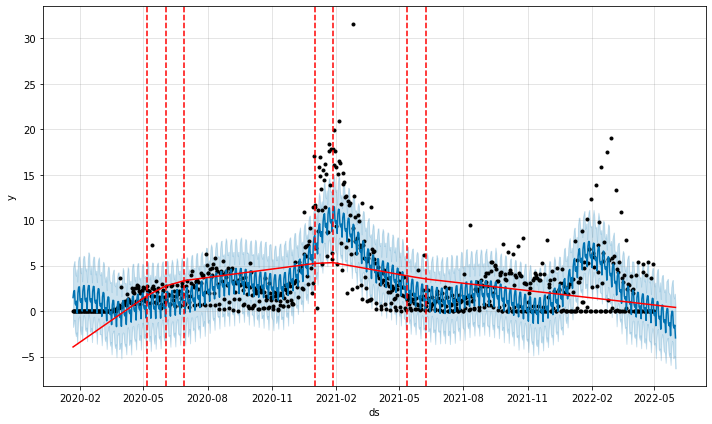

In [13]:
m = Prophet(changepoint_prior_scale=0.05)
m.fit(eg)
future = m.make_future_dataframe(periods=31)
future['floor'] = 0
fcst = m.predict(future)
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)

/Users/1022399/opt/miniconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/1022399/opt/miniconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/1022399/opt/miniconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.5242
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1602.71    0.00250744       157.773      0.5949      0.5949      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1617.56   0.000451822       76.5135       0.651       0.651      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       1617.72    0.00103864         245.4    1.12e-05       0.001      290  LS failed, Hessian reset 
     270       1618.21   0.000344466       131.595   1.965e-06       0.001      400  LS failed, Hessian reset 
     299       1618.39   4.58352e-06        67.741      0.3726           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343       1618.39   8.84297e-09       71.5431     0.04155           1      501   
Optimization terminat

/Users/1022399/opt/miniconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/1022399/opt/miniconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/1022399/opt/miniconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/1022399/opt/miniconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

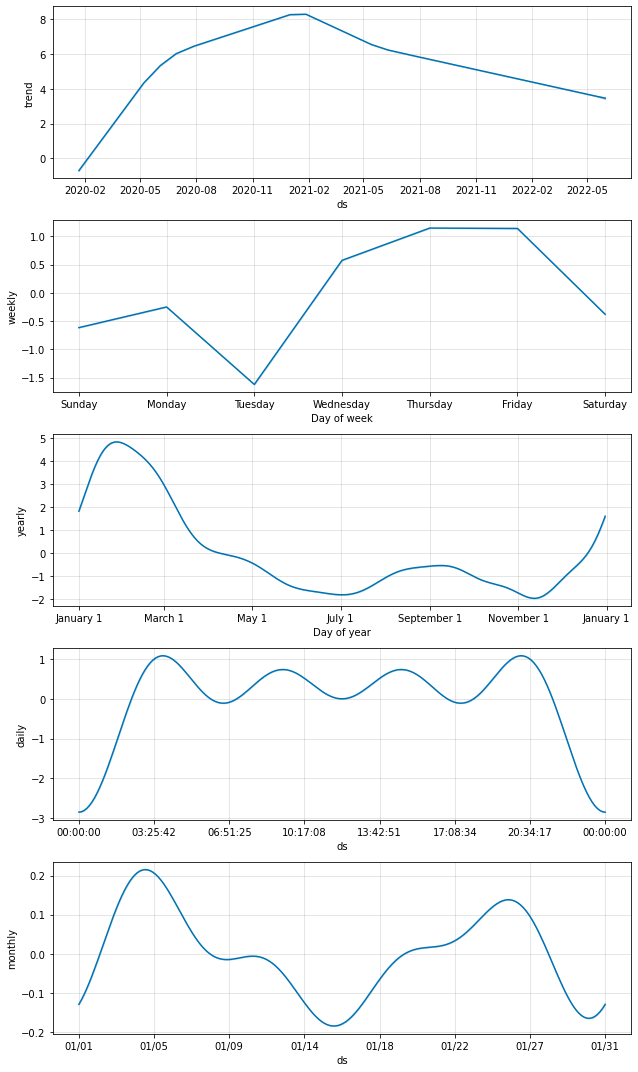

In [14]:
m2 = Prophet(daily_seasonality=True)
m2.add_seasonality(name='monthly', period=30.5, fourier_order=4)
forecast = m2.fit(eg).predict(future)
fig = m2.plot_components(forecast)

In [ ]:
df_cv = cross_validation(m, initial='100 days', period='180 days', horizon = '365 days')
df_cv.head()

In [29]:
df_cv['yhat'][df_cv['yhat']<0]=0
print(np.mean(np.abs(df_cv['yhat']-df_cv['y'])))

2.9848369686257947


/var/folders/6g/4lnv3n4n28q31_0pwbqllvz00000gp/T/ipykernel_74713/1868125360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cv['yhat'][df_cv['yhat']<0]=0


In [ ]:
lstates = list(wtrain.columns)
states = lstates[1:len(lstates)]
wtrain_result = list()

for st in states:
    df = wtrain[['ds',st]]
    df['floor'] = 0
    df = df.rename(columns = {st:'y'})
    model = Prophet(changepoint_prior_scale=0.01)
    model.fit(df)
    future =  model.make_future_dataframe(periods=110)
    fcst = model.predict(future)
    fcst = fcst[['ds', 'yhat']]
    fcst['yhat'][fcst['yhat']<0]=0
    fcst = fcst.rename(columns= {'yhat':st})
    wtrain_result.append(fcst)

In [33]:
wtrain_result = pd.concat([r.set_index('ds') for r in wtrain_result], axis=1).reset_index()
wtrain_result.head()

,ds,Alabama,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,2020-01-22,9.879363,15.863562,4.749679,5.062310,4.669701,11.096552,10.288850,7.534705,6.490924,...,10.201600,10.368073,7.455410,3.354188,1.455107,2.405887,3.932250,6.832001,6.561559,1.781112
1,2020-01-23,9.489813,13.144109,3.848695,5.626121,4.522548,9.221161,10.325688,7.341127,6.375045,...,9.969441,9.738262,7.320490,2.912843,1.533788,2.582049,3.428440,5.340899,6.234554,3.153633
2,2020-01-24,9.336727,12.865237,3.801268,5.603901,4.005317,10.366521,10.206067,6.735282,6.377897,...,8.802641,10.275635,7.012936,2.861268,1.206792,2.396230,3.540739,4.389183,5.703086,1.044897
3,2020-01-25,9.176217,12.231463,2.924306,4.061934,1.989244,6.797140,9.422784,5.970287,5.966455,...,7.602061,8.999819,6.426626,1.220568,1.089636,0.541342,0.770233,0.719331,4.122123,0.281747
4,2020-01-26,8.751326,7.292899,3.212383,3.797591,1.512866,5.983196,9.077021,5.751714,5.725048,...,5.534663,6.153128,5.197456,1.057036,1.006026,0.921108,0.610954,0.000000,2.455749,0.000000


In [35]:
result = pd.melt(wtrain_result, id_vars='ds', value_vars=states).rename(columns = {'value':'cases_per_mil', 'variable':'State'})
result = contiguous_usa.merge(result, left_on = 'state', right_on= 'State')
result = result.sort_values(by=['ds','State'])

In [48]:
ldf = list(result.groupby('ds'))
c = [ x[1] for x in ldf]

In [54]:
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import matplotlib.pyplot as plt

def plot_choropleth (df,i):
  date = pd.to_datetime(df['ds'].unique()[0])
  dia = str(date.day) if date.day>9 else '0'+str(date.day)
  mes = str(date.month) if date.month>9 else '0'+str(date.month)
  anio = str(date.year)
  d = anio+'-'+mes+'-'+dia
  
  ax = gplt.choropleth(
    df,
    hue="cases_per_mil",
    edgecolor="black",
    linewidth=5,
    cmap="Reds",
    alpha=0.8,
    projection=gcrs.AlbersEqualArea(),
    figsize=(12, 12)
  )
  
  ax.set_title(
    f"REAL COVID-19 cases/million on {d}",
    fontsize=36
  )
  
  file_name = str('/covid_plots/img-{}.png'.format(i))
  plt.savefig(file_name, bbox_inches="tight", pad_inches=0.1)
  
  return file_name

In [ ]:
images = []
i=1
for cc in c:
    images.append(plot_choropleth(df = cc,i = i))
    i = i+1

In [ ]:
import imageio
gif_images=list()
for file_name in images[710:937]:
  gif_images.append(imageio.imread(file_name))

In [58]:
gif_path = "/anim/covid.gif"
imageio.mimsave(gif_path, gif_images, fps=7)

<img src="https://github.com/maxmprado/tsprophet/blob/master/anim/covid.gif" style="height: 300px; width:500px;"/>
<img src="https://github.com/maxmprado/tsprophet/blob/master/anim/covid_real.gif" style="height: 300px; width:500px;"/>